In [1]:
import math
import pandas as pd
from pyspark.sql import Row
from pyspark.ml.linalg import Vectors
from pyspark.ml.clustering import KMeans
import matplotlib.pylab as plt
%matplotlib inline

In [2]:
session = SparkSession.builder.master("local").appName("clusterization").getOrCreate()

In [4]:
rdd_raw = sc.textFile("data/carros2.csv")
rdd_raw.cache()

data/carros2.csv MapPartitionsRDD[1] at textFile at NativeMethodAccessorImpl.java:0

In [5]:
rdd_raw.count()

198

In [6]:
rdd_raw.take(5)

['MAKE,FUELTYPE,ASPIRE,DOORS,BODY,DRIVE,CYLINDERS,HP,RPM,MPG-CITY,MPG-HWY,PRICE',
 'subaru,gas,std,two,hatchback,fwd,four,69,4900,31,36,5118',
 'chevrolet,gas,std,two,hatchback,fwd,three,48,5100,47,53,5151',
 'mazda,gas,std,two,hatchback,fwd,four,68,5000,30,31,5195',
 'toyota,gas,std,two,hatchback,fwd,four,62,4800,35,39,5348']

### Preparação de dados


In [8]:
header = rdd_raw.first()

In [12]:
rdd_data = rdd_raw.filter(lambda line: line != header)
rdd_data.cache()
rdd_data.take(5)

['subaru,gas,std,two,hatchback,fwd,four,69,4900,31,36,5118',
 'chevrolet,gas,std,two,hatchback,fwd,three,48,5100,47,53,5151',
 'mazda,gas,std,two,hatchback,fwd,four,68,5000,30,31,5195',
 'toyota,gas,std,two,hatchback,fwd,four,62,4800,35,39,5348',
 'mitsubishi,gas,std,two,hatchback,fwd,four,68,5500,37,41,5389']

In [18]:
for i in header.split(","):
    print(i.lower(),"=")

make =
fueltype =
aspire =
doors =
body =
drive =
cylinders =
hp =
rpm =
mpg-city =
mpg-hwy =
price =


In [21]:
def transformToNumeric(line):
    lineList = line.split(",")
    doors = 1.0 if lineList[3] == "two" else 2.0
    body = 1.0 if lineList[4] == "sedan" else 2.0
    hp = float(lineList[7])
    rpm = float(lineList[8])
    mpg = float(lineList[9])
    
    row =Row(doors=doors, body=body, hp=hp, rpm=rpm, mpg=mpg)    
    return row
    
    

In [25]:
rdd_transf = rdd_data.map(transformToNumeric)
rdd_transf.persist()
rdd_transf.take(5)

[Row(body=2.0, doors=1.0, hp=69.0, mpg=31.0, rpm=4900.0),
 Row(body=2.0, doors=1.0, hp=48.0, mpg=47.0, rpm=5100.0),
 Row(body=2.0, doors=1.0, hp=68.0, mpg=30.0, rpm=5000.0),
 Row(body=2.0, doors=1.0, hp=62.0, mpg=35.0, rpm=4800.0),
 Row(body=2.0, doors=1.0, hp=68.0, mpg=37.0, rpm=5500.0)]

In [30]:
df_cars = session.createDataFrame(rdd_transf)
df_cars.show()

+----+-----+----+----+------+
|body|doors|  hp| mpg|   rpm|
+----+-----+----+----+------+
| 2.0|  1.0|69.0|31.0|4900.0|
| 2.0|  1.0|48.0|47.0|5100.0|
| 2.0|  1.0|68.0|30.0|5000.0|
| 2.0|  1.0|62.0|35.0|4800.0|
| 2.0|  1.0|68.0|37.0|5500.0|
| 2.0|  1.0|60.0|38.0|5500.0|
| 1.0|  1.0|69.0|31.0|5200.0|
| 2.0|  1.0|68.0|37.0|5500.0|
| 2.0|  1.0|68.0|37.0|5500.0|
| 2.0|  1.0|68.0|31.0|5000.0|
| 2.0|  1.0|68.0|31.0|5500.0|
| 2.0|  2.0|68.0|31.0|5500.0|
| 2.0|  2.0|68.0|31.0|5500.0|
| 2.0|  1.0|70.0|38.0|5400.0|
| 2.0|  1.0|62.0|31.0|4800.0|
| 2.0|  1.0|68.0|31.0|5500.0|
| 2.0|  1.0|58.0|49.0|4800.0|
| 2.0|  2.0|62.0|31.0|4800.0|
| 2.0|  1.0|76.0|30.0|6000.0|
| 1.0|  2.0|70.0|38.0|5400.0|
+----+-----+----+----+------+
only showing top 20 rows



In [36]:
stats = df_cars.describe().toPandas()
stats.head()

,summary,body,doors,hp,mpg,rpm
0,count,197,197,197,197,197
1,mean,1.532994923857868,1.5685279187817258,103.60406091370558,25.15228426395939,5118.0203045685275
2,stddev,0.5001812579359883,0.49654352778167493,37.639205349518356,6.437862917085915,481.03591405011446
3,min,1.0,1.0,48.0,13.0,4150.0
4,max,2.0,2.0,262.0,49.0,6600.0


In [44]:
means = stats.iloc[1, 1:5].values.tolist()
means

['1.532994923857868',
 '1.5685279187817258',
 '103.60406091370558',
 '25.15228426395939']

In [45]:
sd = stats.iloc[2, 1:5].values.tolist()
sd

['0.5001812579359883',
 '0.49654352778167493',
 '37.639205349518356',
 '6.437862917085915']

In [69]:
MEANS = sc.broadcast(means)
SD = sc.broadcast(sd)

In [70]:
def centerAndScale(row):
    global MEANS
    global SD
    
    mean_array = MEANS.value
    sd_array = SD.value
    
    result = []
    
    for i in range(len(mean_array)):
        result.append(float(row[i]) - float(mean_array[i]) / float(sd_array[i]))
    
    return Vectors.dense(result)
    

In [71]:
df_centered = df_cars.rdd.map(centerAndScale)
df_centered.take(5)

[DenseVector([-1.0649, -2.1589, 66.2474, 27.0931]),
 DenseVector([-1.0649, -2.1589, 45.2474, 43.0931]),
 DenseVector([-1.0649, -2.1589, 65.2474, 26.0931]),
 DenseVector([-1.0649, -2.1589, 59.2474, 31.0931]),
 DenseVector([-1.0649, -2.1589, 65.2474, 33.0931])]

In [73]:
df_features = df_centered.map(lambda row: Row(features=row))

In [77]:
df_inputs = session.createDataFrame(df_features)
df_inputs.show(5)

+--------------------+
|            features|
+--------------------+
|[-1.0648787805121...|
|[-1.0648787805121...|
|[-1.0648787805121...|
|[-1.0648787805121...|
|[-1.0648787805121...|
+--------------------+
only showing top 5 rows



In [79]:
clusterizer = KMeans(k=3, seed=1)

In [80]:
model = clusterizer.fit(df_inputs)

In [82]:
# predictions
predictions = model.transform(df_inputs)
predictions.show(5)

+--------------------+----------+
|            features|prediction|
+--------------------+----------+
|[-1.0648787805121...|         1|
|[-1.0648787805121...|         1|
|[-1.0648787805121...|         1|
|[-1.0648787805121...|         1|
|[-1.0648787805121...|         1|
+--------------------+----------+
only showing top 5 rows



In [87]:
def unstripData(line):
    return (line["prediction"], line["features"][0], line["features"][1], line["features"][2], line["features"][3])

In [91]:
df_predictions = predictions.rdd.map(unstripData)
df_final = pd.DataFrame(df_predictions.collect())
df_final.head()

,0,1,2,3,4
0,1,-1.064879,-2.158893,66.247443,27.093069
1,1,-1.064879,-2.158893,45.247443,43.093069
2,1,-1.064879,-2.158893,65.247443,26.093069
3,1,-1.064879,-2.158893,59.247443,31.093069
4,1,-1.064879,-2.158893,65.247443,33.093069


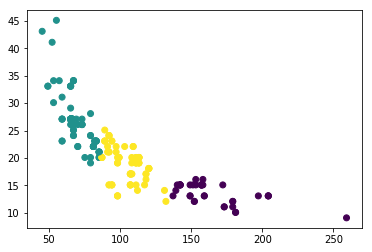

In [92]:
plt.cla()
plt.scatter(df_final[3], df_final[4], c = df_final[0])